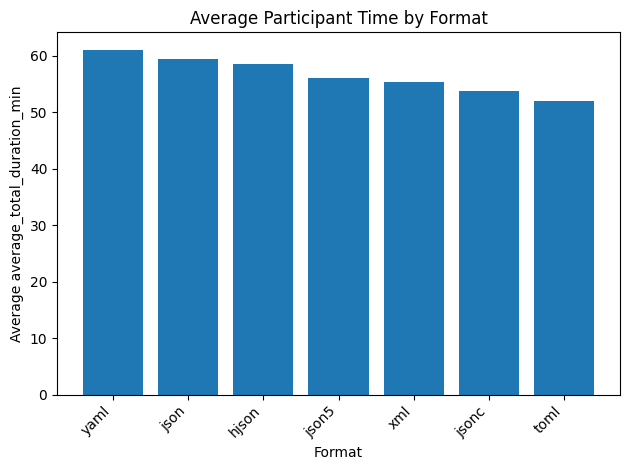

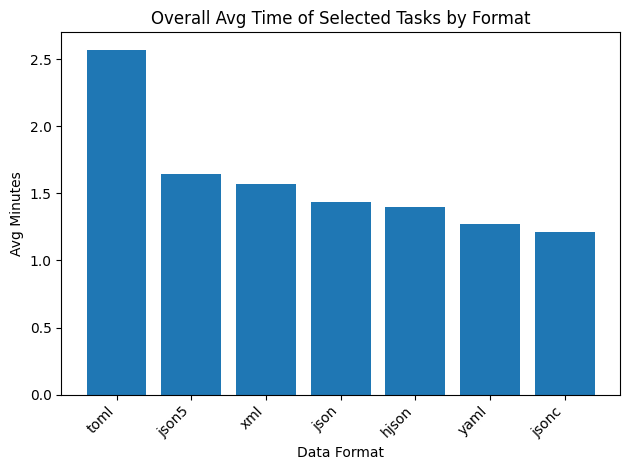

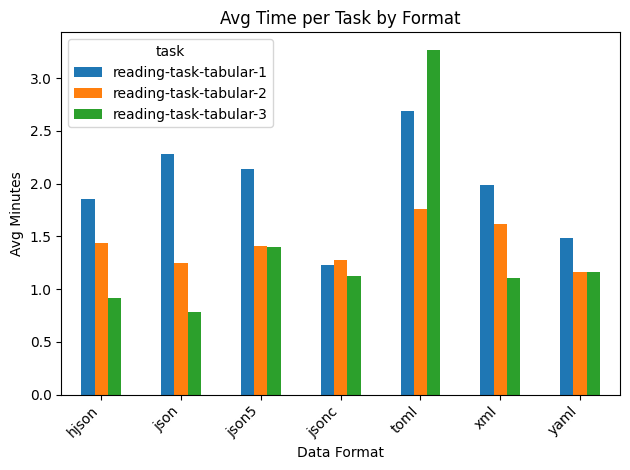

In [31]:
import sys
sys.path.append('/Users/shiyihe/Desktop/USABILITY_ANALYSIS')   

from duration_processor import (
    load_quiz_data,
    extract_format_time,
    sanitize_task_names,
    summarize_participant_by_format,
    plot_participant_time_by_format,
    summarize_tasks_by_format,
    plot_tasks_time_by_format,
    filter_tasks_by_list,
    participant_format_statistics,
    diagnose_all_json
)


# load data , rename task name, etc,.
folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/tabular'
all_data = load_quiz_data(folder, ignore_completed=True)

# extract format and duration
# df_participant: summarize participant's total time spent by format
df_task, df_participant = extract_format_time(all_data)

# clean 'format' from task name
df_task_clean = sanitize_task_names(df_task)

# average total time spent by format
df_part_summary = summarize_participant_by_format(df_participant)
fig1 = plot_participant_time_by_format(df_part_summary)

# 1. all tasks average time spent by format
task_list=['reading-task-tabular-1', 'reading-task-tabular-2', 'reading-task-tabular-3']
df_filtered = filter_tasks_by_list(df_task_clean, task_list)

df_overall = summarize_tasks_by_format(
    df_task_clean,
    metric='duration_min',
    task_list=task_list,
    mode='overall'
)
fig2 = plot_tasks_time_by_format(
    df_overall,
    metric='average_duration_min',
    mode='overall',
    title='Overall Avg Time of Selected Tasks by Format',
    xlabel='Data Format',
    ylabel='Avg Minutes'
)

# 2. each task average time spent by format
df_by_task = summarize_tasks_by_format(
    df_task_clean,
    task_list=task_list,
    metric='duration_min',
    mode='by_task'
)
fig3 = plot_tasks_time_by_format(
    df_by_task,
    metric='average_duration_min',
    mode='by_task',
    title='Avg Time per Task by Format',
    xlabel='Data Format',
    ylabel='Avg Minutes'
)

# df_task
# df_participant
# loaded, errors = diagnose_all_json(folder)

In [32]:
format_counts = participant_format_statistics(df_participant)
print(format_counts)

Total number of valid participants: 105
format
json     17
hjson    15
yaml     15
toml     15
jsonc    15
xml      15
json5    13
Name: count, dtype: int64


In [ ]:
all_data


Statsmodels ANOVA table:
                 sum_sq    df         F    PR(>F)
C(format)   1069.721103   6.0  0.464344  0.833103
Residual   36475.616281  95.0       NaN       NaN

result interpretation: 
Levene's test for homogeneity of variances: W = 0.456, p = 0.839 (> 0.05). Variances are not significantly different.
One-way ANOVA: F = 0.464, p = 0.833.
→ p ≥ 0.05: Cannot reject the null hypothesis; no significant difference in means between groups.



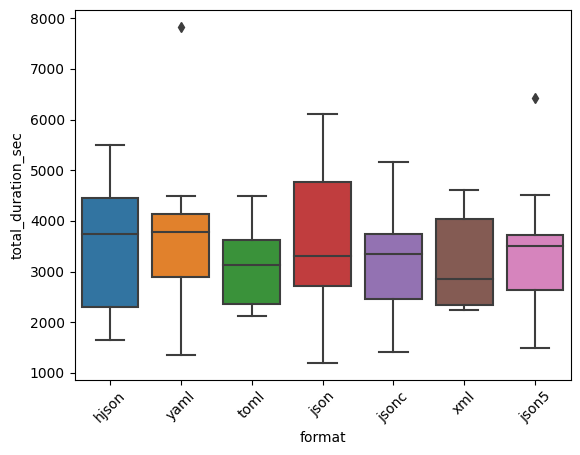


Outliers detected:


,participantId,format,total_duration_sec,total_duration_min,outlier_group,lower_bound,upper_bound
0,67d163e7b7bcc1e9718e01da,json5,6416.125,106.94,json5,1012.659625,5351.960625
1,671a519900a99ebc15a67672,yaml,7830.358,130.51,yaml,1023.662750,5991.352750


In [23]:
import pandas as pd
from scipy.stats import levene, f_oneway, kruskal
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt

def test_duration_by_format(
    df: pd.DataFrame,
    duration_col: str = 'total_duration_min',
    factor_col: str = 'format'
) -> dict:
    """
    Perform Levene's test for homogeneity of variances, followed by either
    one-way ANOVA or Kruskal–Wallis test on `duration_col` grouped by `factor_col`.
    Returns a dictionary containing:
      - 'levene': (statistic, p-value)
      - 'method': 'ANOVA' or 'Kruskal–Wallis'
      - 'stat': F-statistic or H-statistic
      - 'p_value': p-value of the chosen test
      - 'tukey': TukeyHSDResults object if ANOVA was used, else None
      - 'anova_table': pandas DataFrame with Type II ANOVA table from statsmodels
    """
    # Prepare a list of arrays, one per group
    grouped = df.groupby(factor_col)
    groups = [group[duration_col].values for _, group in grouped]
    if len(groups) < 2:
        raise ValueError("At least two groups are required for the comparison.")

    # 1) Levene's test for homogeneity of variances
    w_stat, p_levene = levene(*groups)

    # 2) Choose between ANOVA and Kruskal–Wallis based on Levene's result
    if p_levene > 0.05:
        stat, pval = f_oneway(*groups)
        method = 'ANOVA'
    else:
        stat, pval = kruskal(*groups)
        method = 'Kruskal–Wallis'

    # 3) If ANOVA was used, perform Tukey HSD post-hoc comparisons
    tukey = None
    if method == 'ANOVA':
        tukey = pairwise_tukeyhsd(
            endog=df[duration_col],
            groups=df[factor_col],
            alpha=0.05
        )

    # 4) Generate a Type II ANOVA table with statsmodels
    model = ols(f'{duration_col} ~ C({factor_col})', data=df).fit()
    anova_table = anova_lm(model, typ=2)

    return {
        'levene': (w_stat, p_levene),
        'method': method,
        'stat': stat,
        'p_value': pval,
        'tukey': tukey,
        'anova_table': anova_table
    }

def interpret_duration_results(results: dict) -> str:
    """
    Generate an English interpretation of the statistical test results
    dictionary returned by `test_duration_by_format`.
    """
    w_stat, p_levene = results['levene']
    method = results['method']
    stat = results['stat']
    pval = results['p_value']

    lines = []
    # Interpret Levene's test
    if p_levene > 0.05:
        lines.append(
            f"Levene's test for homogeneity of variances: W = {w_stat:.3f}, "
            f"p = {p_levene:.3f} (> 0.05). Variances are not significantly different.\n"
        )
    else:
        lines.append(
            f"Levene's test for homogeneity of variances: W = {w_stat:.3f}, "
            f"p = {p_levene:.3f} (≤ 0.05). Variances differ significantly; "
            f"using {method}.\n"
        )

    # Interpret main test
    if method == 'ANOVA':
        lines.append(f"One-way ANOVA: F = {stat:.3f}, p = {pval:.3f}.\n")
        if pval < 0.05:
            lines.append(
                "→ p < 0.05: Reject the null hypothesis of equal means; "
                "there is a significant difference between groups.\n"
            )
            lines.append(
                "  Check the Tukey HSD results to see which pairs differ.\n"
            )
        else:
            lines.append(
                "→ p ≥ 0.05: Cannot reject the null hypothesis; "
                "no significant difference in means between groups.\n"
            )
    else:
        lines.append(f"Kruskal–Wallis H = {stat:.3f}, p = {pval:.3f}.\n")
        if pval < 0.05:
            lines.append(
                "→ p < 0.05: Reject the null hypothesis; "
                "there is a significant difference between groups.\n"
            )
        else:
            lines.append(
                "→ p ≥ 0.05: Cannot reject the null hypothesis; "
                "no significant difference between groups.\n"
            )

    return "".join(lines)

def extract_outliers(
    df: pd.DataFrame,
    group_col: str,
    value_col: str
) -> pd.DataFrame:
    """
    Identify outliers in `value_col` within each group defined by `group_col`
    using the 1.5 × IQR rule. Returns a DataFrame containing only the outlier rows,
    with additional columns:
      - outlier_group: the group name
      - lower_bound: lower threshold used
      - upper_bound: upper threshold used
    """
    outliers_list = []

    for group_name, group_df in df.groupby(group_col):
        q1 = group_df[value_col].quantile(0.25)
        q3 = group_df[value_col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        mask = (group_df[value_col] < lower_bound) | (group_df[value_col] > upper_bound)
        outlier_rows = group_df.loc[mask].copy()
        if not outlier_rows.empty:
            outlier_rows['outlier_group'] = group_name
            outlier_rows['lower_bound'] = lower_bound
            outlier_rows['upper_bound'] = upper_bound
            outliers_list.append(outlier_rows)

    if outliers_list:
        return pd.concat(outliers_list, ignore_index=True)
    else:
        # Return an empty DataFrame with the same structure
        cols = list(df.columns) + ['outlier_group', 'lower_bound', 'upper_bound']
        return pd.DataFrame(columns=cols)

# ========== Example Usage ==========

# Assume df_participant is already loaded and contains:
# ['participantId', 'format', 'total_duration_min']

# Run the statistical tests
results = test_duration_by_format(
    df_participant,
    duration_col='total_duration_min',
    factor_col='format'
)

print("\nStatsmodels ANOVA table:")
print(results['anova_table'])

print("\nresult interpretation: ")
print(interpret_duration_results(results))

outliers = extract_outliers(df_participant, 'format', 'total_duration_sec')


sns.boxplot(x='format', y='total_duration_sec', data=df_participant)
plt.xticks(rotation=45)
plt.show()

print("\nOutliers detected:")
outliers

In [25]:
import pandas as pd
import re
from scipy.stats import levene, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def process_task_data(df_task: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and aggregate task-level duration data.

    Steps:
      1. Keep only relevant columns.
      2. Remove tasks ending with '_post-task-question' and 'unqualified'.
      3. Preserve original task rows (task_group = task).
      4. Aggregate all 'modifying-', 'reading-', and 'writing-task-tabular-' subtasks
         into their parent task_group by summing duration_min.
      5. Aggregate all 'tutorial-<format>-partX' subtasks into 'tutorial-<format>' 
         by summing duration_min.
    Returns a DataFrame with columns:
      ['participantId', 'task_group', 'format', 'duration_min']
    """
    # Select and filter relevant rows
    df = df_task[['participantId', 'task', 'duration_min', 'format']].copy()
    df = df[~df['task'].str.endswith('_post-task-question')]
    df = df[df['task'] != 'unqualified']
    
    # 1) Preserve original rows: task_group = original task name
    df_orig = df.rename(columns={'task': 'task_group'})[
        ['participantId', 'task_group', 'format', 'duration_min']
    ]
    
    agg_frames = []
    # 2) Aggregate tabular subtasks into top-level task_group
    for prefix in ['modifying-task-tabular', 'reading-task-tabular', 'writing-task-tabular']:
        mask = df['task'].str.startswith(prefix + '-')
        if mask.any():
            tmp = (
                df[mask]
                .groupby(['participantId', 'format'], as_index=False)['duration_min']
                .sum()
            )
            tmp['task_group'] = prefix
            agg_frames.append(tmp[['participantId', 'task_group', 'format', 'duration_min']])
    
    # 3) Aggregate tutorial subtasks into 'tutorial-<format>'
    tutorial_mask = df['task'].str.match(r'^tutorial-[^-]+-part\d+$')
    if tutorial_mask.any():
        df_tut = df[tutorial_mask].copy()
        df_tut['task_group'] = df_tut['task'].str.replace(r'-part\d+$', '', regex=True)
        tmp2 = (
            df_tut
            .groupby(['participantId', 'format', 'task_group'], as_index=False)['duration_min']
            .sum()
        )
        agg_frames.append(tmp2[['participantId', 'task_group', 'format', 'duration_min']])
    
    # Combine original and aggregated rows
    df_combined = pd.concat([df_orig] + agg_frames, ignore_index=True)
    return df_combined


def test_format_duration(df_combined: pd.DataFrame, task_list: list):
    """
    For each task in task_list (raw or aggregated name):
      1. Canonicalize the task name (e.g., 'modifying-task-tabular-1' → 'modifying-task-tabular').
      2. Ensure there are at least two formats; skip otherwise.
      3. Perform Levene's test for variance homogeneity.
      4. If variances are homogeneous, run one-way ANOVA; else run Kruskal–Wallis.
      5. If ANOVA was used, perform Tukey HSD post-hoc comparisons.
      6. Print results and return a dictionary of statistics.
    """
    results = {}
    for raw_task in task_list:
        # Map raw_task to its canonical aggregated name
        canonical = raw_task
        for prefix in ['modifying-task-tabular', 'reading-task-tabular', 'writing-task-tabular']:
            if raw_task.startswith(prefix + '-'):
                canonical = prefix
                break
        else:
            if re.match(r'^tutorial-[^-]+-part\d+$', raw_task):
                canonical = re.sub(r'-part\d+$', '', raw_task)
        
        sub = df_combined[df_combined['task_group'] == canonical]
        if sub.empty:
            print(f"⚠️ No data found for task '{raw_task}' (canonical '{canonical}'), skipping.")
            continue
        
        formats = sub['format'].unique()
        if len(formats) < 2:
            print(f"⚠️ Task '{raw_task}' (canonical '{canonical}') has only one format: {formats.tolist()}, skipping.")
            continue
        
        # Prepare groups of duration values
        groups = [group['duration_min'].values for _, group in sub.groupby('format')]
        
        # 1) Levene's test
        w_stat, p_levene = levene(*groups)
        
        # 2) Choose test based on variance homogeneity
        if p_levene > 0.05:
            stat, pval = f_oneway(*groups)
            method = 'ANOVA'
        else:
            stat, pval = kruskal(*groups)
            method = 'Kruskal–Wallis'
        
        # 3) Tukey HSD if ANOVA
        tukey = None
        if method == 'ANOVA':
            tukey = pairwise_tukeyhsd(
                endog=sub['duration_min'],
                groups=sub['format'],
                alpha=0.05
            )
        
        # Print results
        print(f"\n=== Task: {raw_task} → Aggregated as: {canonical} ===")
        print(f"Levene's test: W = {w_stat:.3f}, p = {p_levene:.3f}")
        if method == 'ANOVA':
            print(f"One-way ANOVA: F = {stat:.3f}, p = {pval:.3f}")
            print(tukey)
        else:
            print(f"Kruskal–Wallis: H = {stat:.3f}, p = {pval:.3f}")
        print('-' * 40)
        
        results[raw_task] = {
            'canonical': canonical,
            'method': method,
            'stat': stat,
            'p_value': pval,
            'levene': (w_stat, p_levene),
            'tukey': tukey
        }
    return results


def generate_interpretation(results: dict) -> dict:
    """
    Given the output of test_format_duration, automatically generate
    an English interpretation for each task.
    Returns a dict mapping raw_task to its interpretation string.
    """
    interpretations = {}
    for raw_task, info in results.items():
        canonical = info['canonical']
        w_stat, p_levene = info['levene']
        method = info['method']
        stat = info['stat']
        pval = info['p_value']
        
        lines = [f"=== Task: '{raw_task}' (aggregated as '{canonical}') ===\n"]
        
        # Interpret Levene's test
        if p_levene > 0.05:
            lines.append(
                f"Levene's test p = {p_levene:.3f} (> 0.05): "
                "variances are homogeneous across formats.\n"
            )
        else:
            lines.append(
                f"Levene's test p = {p_levene:.3f} (≤ 0.05): "
                "variances are not homogeneous; proceeding with "
                f"{method}.\n"
            )
        
        # Interpret main test
        if method == 'ANOVA':
            lines.append(f"One-way ANOVA result: F = {stat:.3f}, p = {pval:.3f}.\n")
            if pval < 0.05:
                lines.append(
                    "→ p < 0.05: Reject the null hypothesis of equal means; "
                    "significant differences exist between formats.\n"
                )
                lines.append(
                    "  Check Tukey HSD post-hoc comparisons to identify which pairs differ.\n"
                )
            else:
                lines.append(
                    "→ p ≥ 0.05: Cannot reject the null hypothesis; "
                    "no significant differences in mean duration across formats.\n"
                )
        else:
            lines.append(f"Kruskal–Wallis result: H = {stat:.3f}, p = {pval:.3f}.\n")
            if pval < 0.05:
                lines.append(
                    "→ p < 0.05: Reject the null hypothesis; "
                    "significant differences exist between formats.\n"
                )
            else:
                lines.append(
                    "→ p ≥ 0.05: Cannot reject the null hypothesis; "
                    "no significant differences between formats.\n"
                )
        
        interpretations[raw_task] = "".join(lines)
    return interpretations



In [28]:
df_proc = process_task_data(df_task)
df_proc['task_group'].unique()

array(['introduction', 'qualifications', 'consent', 'task',
       'writing-task-NL', 'tutorial-hjson-part1', 'tutorial-hjson-part2',
       'reading-task-tabular-hjson-1', 'reading-task-tabular-hjson-2',
       'reading-task-tabular-hjson-3', 'reading-task-tabular-hjson-4',
       'reading-task-tabular-hjson-5', 'writing-task-tabular-hjson',
       'modifying-task-tabular-hjson-1', 'modifying-task-tabular-hjson-2',
       'modifying-task-tabular-hjson-3', 'modifying-task-tabular-hjson-4',
       '$nasa-tlx.co.nasa-tlx', 'post-task-survey-tlx',
       'tutorial-yaml-part1', 'tutorial-yaml-part2',
       'reading-task-tabular-yaml-1', 'reading-task-tabular-yaml-2',
       'reading-task-tabular-yaml-3', 'reading-task-tabular-yaml-4',
       'reading-task-tabular-yaml-5', 'writing-task-tabular-yaml',
       'modifying-task-tabular-yaml-1', 'modifying-task-tabular-yaml-2',
       'modifying-task-tabular-yaml-3', 'modifying-task-tabular-yaml-4',
       'tutorial-toml-part1', 'tutorial-toml-

In [30]:
tasks = [
    'modifying-task-tabular',
    'modifying-task-tabular-1',
    'modifying-task-tabular-2',
    'modifying-task-tabular-3',
    'modifying-task-tabular-4',
    'reading-task-tabular',
    'reading-task-tabular-1',
    'reading-task-tabular-2',
    'reading-task-tabular-3',
    'reading-task-tabular-4',
    'reading-task-tabular-5',
    'writing-task-tabular',
    'writing-task-NL'
]
res = test_format_duration(df_proc, tasks)
interpretations = generate_interpretation(res)
for raw, txt in interpretations.items():
    print(txt)



=== Task: modifying-task-tabular → Aggregated as: modifying-task-tabular ===
Levene's test: W = 0.428, p = 0.859
One-way ANOVA: F = 1.342, p = 0.246
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
 hjson   json    0.495    1.0  -7.8965  8.8865  False
 hjson  json5  -0.8794    1.0 -10.0538  8.2951  False
 hjson  jsonc  -2.7633 0.9607  -11.413  5.8865  False
 hjson   toml  -2.2234  0.988 -11.0263  6.5795  False
 hjson    xml   0.0675    1.0  -8.7354  8.8704  False
 hjson   yaml   4.4793 0.7077  -4.1705 13.1291  False
  json  json5  -1.3744 0.9992 -10.3058   7.557  False
  json  jsonc  -3.2583 0.9037 -11.6498  5.1332  False
  json   toml  -2.7184 0.9616 -11.2676  5.8309  False
  json    xml  -0.4275    1.0  -8.9768  8.1217  False
  json   yaml   3.9843 0.7841  -4.4072 12.3758  False
 json5  jsonc  -1.8839 0.9961 -11.0584  7.2906  False
 json5   toml   -1.344 0.9995  -10.663  